# Programming Exercise 3: Inference for Probabilistic Graphical Models

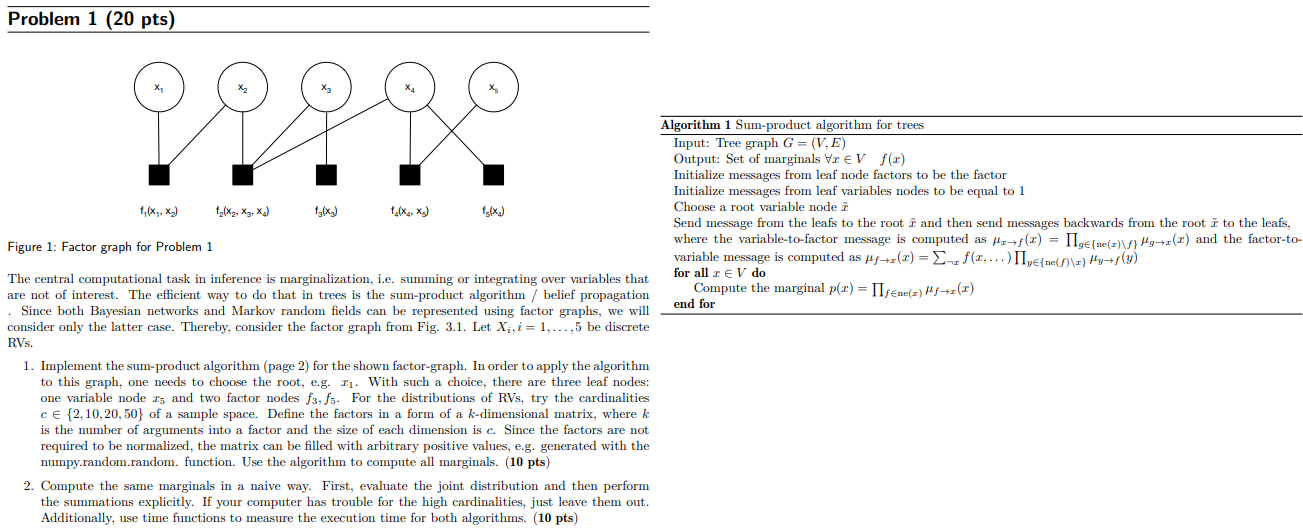

#### Observation

A "k-dimensional matrix with each dimension having a size of c" is a data structure with "k nested" lists (one list inside the other) and the range of each list is given by "0...c-1".
In this case, the factors $f_i(x_1, x_2, ..., x_k)$ are given by a data structure made up of $k$ nested lists. The list in level 1 (outer list) has length given by the number of elements of the domain of $x_1$, the list in level 2 corresponds to the $x_2$ and so on. 

In [124]:
import numpy as np
import numpy.testing as npt 
import itertools
import time


In [125]:
class FactorNode:
    def __init__(self, name: str, variable_nodes: list, factor_function: np.ndarray):
        self.factor_function = factor_function
        self.variable_nodes = variable_nodes
        self.name = name
        self.num_of_variables = len(variable_nodes)
        incoming_msgs = {}
        sending_msgs = {}

        for variable_index in range(len(variable_nodes)):
            variable_node = variable_nodes[variable_index]

            if (variable_node.cardinality != factor_function.shape[variable_index]):
                raise ValueError("Error: inconsistent cardinality of variable {} and size of dimension {} in the factor node".format(str(variable_node, variable_index)))
            
            variable_node.connect_factor_node(self)
            incoming_msgs[str(variable_node)] = None
            sending_msgs[str(variable_node)] = None
        
        self.incoming_msgs = incoming_msgs
        self.sending_msgs = sending_msgs
    
    def __str__(self):
        return self.name
    
    def send_msg(self, dest_variable_node):
        if (dest_variable_node in self.variable_nodes):
            if (len(self.variable_nodes) == 1):
                msg_to_dest = self.factor_function
            else:
                msg_to_dest = self.create_msg(dest_variable_node)
            
            self.sending_msgs[str(dest_variable_node)] = msg_to_dest
            dest_variable_node.receive_msg(msg_to_dest, self)
        else:
            print("Error: destination variable node unreachable")
    
    def create_msg(self, dest_variable_node):
        product = self.factor_function.copy()
        axis_dest_variable = self.variable_nodes.index(dest_variable_node)
        for variable_node in self.variable_nodes:
            if (variable_node != dest_variable_node):
                msg = self.incoming_msgs[str(variable_node)]
                axis_of_variable = self.variable_nodes.index(variable_node)

                slices_for_expansion = [np.newaxis]*self.num_of_variables
                slices_for_expansion[axis_of_variable] = slice(None)

                msg_expanded = msg[tuple(slices_for_expansion)]

                product = product*msg_expanded

        sum_over_axes = tuple(i for i in range(self.num_of_variables) if i != axis_dest_variable)
        
        return np.sum(product, axis=sum_over_axes)

    
    def receive_msg(self, msg, source_node):
        if source_node in self.variable_nodes:
            self.incoming_msgs[str(source_node)] = msg

    def show_variable_nodes(self):
        variables_list = [str(variable_node) for variable_node in self.variable_nodes]
        print("Variable Nodes of {}: {}".format(self.name, variables_list))
    
    def show_incoming_msgs(self):
        print("Messages received by {}: {}".format(self.name, self.incoming_msgs))

    def show_sending_msgs(self):
        print("Messages sent by {}: {}".format(self.name, self.sending_msgs))

In [126]:
class VariableNode:
    def __init__(self, name: str, cardinality: int):
        self.name = name
        self.factor_nodes = []
        self.cardinality = cardinality
        self.incoming_msgs = {}
        self.sending_msgs = {}
        self.marginal_prob = np.zeros(cardinality)
    
    def __str__(self):
        return self.name
    
    def connect_factor_node(self, factor_node: FactorNode):
        self.factor_nodes.append(factor_node)
        self.sending_msgs[str(factor_node)] = None
        self.incoming_msgs[str(factor_node)] = None

    def send_msg(self, dest_factor_node: FactorNode):
        if (dest_factor_node in self.factor_nodes):
            if (len(self.factor_nodes) == 1):
                msg_to_dest = np.ones(self.cardinality)
            else:
                msgs_to_multiply = [msg for variable_node, msg in self.incoming_msgs.items() if variable_node != str(dest_factor_node)]
                msgs_to_multiply_stacked = np.vstack(msgs_to_multiply)
                msg_to_dest = np.prod(msgs_to_multiply_stacked, axis=0)
            
            self.sending_msgs[str(dest_factor_node)] = msg_to_dest
            dest_factor_node.receive_msg(msg_to_dest, self)
        else:
            print("destination factor node unreachable")

    def receive_msg(self, msg, source_node):
        if source_node in self.factor_nodes:
            self.incoming_msgs[str(source_node)] = msg
    
    def show_factor_nodes(self):
        factor_nodes_list = [str(factor) for factor in self.factor_nodes]
        print("Factor Nodes of {}: {}".format(self.name, factor_nodes_list))
    
    def show_incoming_msgs(self):
        print("Messages received by {}: {}".format(self.name, self.incoming_msgs))

    def show_sending_msgs(self):
        print("Messages sent by {}: {}".format(self.name, self.sending_msgs))

    def calculate_marginal_prob(self):
       incoming_msgs_list = list(self.incoming_msgs.values())
       if (any(msg is None for msg in incoming_msgs_list)):
        print("Error: not all messages have been received")
        return None
       else:
        msgs_stacked_for_product = np.vstack(incoming_msgs_list)
        product = np.prod(msgs_stacked_for_product, axis=0)
        self.marginal_prob = product/np.sum(product)
        return self.marginal_prob
    
    def show_marginal_prob(self):
        print("P({}) = {}".format(self.name, self.marginal_prob))

In [127]:
def test_sum_product_algorithm(f1, f2, f3, f4, f5, c):
    x1_node = VariableNode("x1", c)
    x2_node = VariableNode("x2", c)
    x3_node = VariableNode("x3", c)
    x4_node = VariableNode("x4", c)
    x5_node = VariableNode("x5", c)

    f1_node = FactorNode("f1", [x1_node, x2_node], f1)
    f2_node = FactorNode("f2", [x2_node, x3_node, x4_node], f2)
    f3_node = FactorNode("f3",[x3_node] ,f3)
    f4_node = FactorNode("f4",[x4_node, x5_node] ,f4)
    f5_node = FactorNode("f5",[x4_node] ,f5)

    # Forward Propagation from Leafs x5 and x3 to Root x1

    x5_node.send_msg(f4_node)
    f4_node.send_msg(x4_node)

    f5_node.send_msg(x4_node)

    x4_node.send_msg(f2_node)

    f3_node.send_msg(x3_node)
    x3_node.send_msg(f2_node)

    f2_node.send_msg(x2_node)

    x2_node.send_msg(f1_node)
    f1_node.send_msg(x1_node)

    # Backward Propagation from Root x1 to Leafs x5 and x3

    # Path from x1 to center f2
    x1_node.send_msg(f1_node)
    f1_node.send_msg(x2_node)
    x2_node.send_msg(f2_node)

    # Path from center in 'f2' to Leaf x3
    f2_node.send_msg(x3_node)

    # Propagation from center in 'f2' to Leaf x5
    f2_node.send_msg(x4_node)
    x4_node.send_msg(f4_node)
    f4_node.send_msg(x5_node)

    marginal_x1 = x1_node.calculate_marginal_prob()
    marginal_x2 = x2_node.calculate_marginal_prob()
    marginal_x3 = x3_node.calculate_marginal_prob()
    marginal_x4 = x4_node.calculate_marginal_prob()
    marginal_x5 = x5_node.calculate_marginal_prob()

    return {
        "x1": marginal_x1,
        "x2": marginal_x2,
        "x3": marginal_x3,
        "x4": marginal_x4,
        "x5": marginal_x5
    }

In [128]:
def test_naive_marginals(f1, f2, f3, f4, f5, c):
    shape = tuple([c]*5)
    product = np.zeros(shape)

    for id_x1, id_x2, id_x3, id_x4, id_x5 in itertools.product(range(c), repeat=5):
        product[id_x1, id_x2, id_x3, id_x4, id_x5] = f1[id_x1, id_x2]*f2[id_x2, id_x3, id_x4]*f3[id_x3]*f4[id_x4, id_x5]*f5[id_x4]
    
    marginal_x1 = np.sum(product, axis=(1,2,3,4))
    marginal_x1 = marginal_x1/marginal_x1.sum()

    marginal_x2 = np.sum(product, axis=(0,2,3,4))
    marginal_x2 = marginal_x2/marginal_x2.sum()

    marginal_x3 = np.sum(product, axis=(0,1,3,4))
    marginal_x3 = marginal_x3/marginal_x3.sum()

    marginal_x4 = np.sum(product, axis=(0,1,2,4))
    marginal_x4 = marginal_x4/marginal_x4.sum()

    marginal_x5 = np.sum(product, axis=(0,1,2,3))
    marginal_x5 = marginal_x5/marginal_x5.sum()

    return {
        "x1": marginal_x1,
        "x2": marginal_x2,
        "x3": marginal_x3,
        "x4": marginal_x4,
        "x5": marginal_x5
    }


In [129]:
def generate_args_for_tests(c):
    f1 = np.random.random((c, c))
    f2 = np.random.random((c, c, c))
    f3 = np.random.random(c)
    f4 = np.random.random((c, c))
    f5 = np.random.random(c)

    return (f1, f2, f3, f4, f5, c)

## Individual Test of the Functions

In [149]:
# Generating the factor nodes

c = 2

f1 = np.random.random((c, c))
f2 = np.random.random((c, c, c))
f3 = np.random.random(c)
f4 = np.random.random((c, c))
f5 = np.random.random(c)

In [150]:
x1_node = VariableNode("x1", c)
x2_node = VariableNode("x2", c)
x3_node = VariableNode("x3", c)
x4_node = VariableNode("x4", c)
x5_node = VariableNode("x5", c)

f1_node = FactorNode("f1", [x1_node, x2_node], f1)
f2_node = FactorNode("f2", [x2_node, x3_node, x4_node], f2)
f3_node = FactorNode("f3",[x3_node] ,f3)
f4_node = FactorNode("f4",[x4_node, x5_node] ,f4)
f5_node = FactorNode("f5",[x4_node] ,f5)

In [151]:
# Forward Propagation from Leafs x5 and x3 to Root x1

print("1. Before x5 send a msg to f4")
x5_node.show_sending_msgs()
f4_node.show_incoming_msgs()
print("")

x5_node.send_msg(f4_node)

# Test if message passing from leaf variable node works
npt.assert_array_equal(x5_node.sending_msgs["f4"], np.ones(c))

f4_node.send_msg(x4_node)

print("2. After x5 send a msg to f4")
x5_node.show_sending_msgs()
f4_node.show_incoming_msgs()
print("")

print("3. Before f5 send a msg to x4")
f5_node.show_sending_msgs()
x4_node.show_incoming_msgs()
print("")

f5_node.send_msg(x4_node)

# Test if a message passing from leaf factor node works
f5_to_x4 = f5_node.sending_msgs["x4"]
npt.assert_almost_equal(f5_to_x4, f5)

print("4. After f5 send a msg to x4")
f5_node.show_sending_msgs()
x4_node.show_incoming_msgs()
print("")

print("5. Before f3 send a msg to x3")
f3_node.show_sending_msgs()
x3_node.show_incoming_msgs()
print("")

f3_node.send_msg(x3_node)

print("6. After f3 send a msg to x3")
f3_node.show_sending_msgs()
x3_node.show_incoming_msgs()
print("")

print("7. Before x3 and x4 send a msg to f2")
f2_node.show_incoming_msgs()
print("")

x3_node.send_msg(f2_node)
x4_node.send_msg(f2_node)

# Test if a message passing from non-leaf variable node works 
x4_to_f2 = x4_node.sending_msgs["f2"]
x3_to_f2 = x3_node.sending_msgs["f2"]
npt.assert_almost_equal(x4_to_f2, f5*np.sum(f4, axis=1))
npt.assert_almost_equal(x3_to_f2, f3)

print("8. After x3 and x4 send a msg to f2")
f2_node.show_incoming_msgs()
print("")

print("9. Before f2 send a msg to x2")
x2_node.show_incoming_msgs()
print("")

f2_node.send_msg(x2_node)

# Test if a message passing from non terminal factor node works 
f2_to_x2 = f2_node.sending_msgs["x2"]
expected_f2_to_x2 = np.sum(x3_to_f2[np.newaxis, :, np.newaxis]*x4_to_f2[np.newaxis, np.newaxis, :]*f2, axis=(1,2)) # product of f2 with messages from x3 and x4, and then marginalization of x3 and x4
npt.assert_almost_equal(f2_to_x2, expected_f2_to_x2)

print("10. After f2 send a msg to x2")
x2_node.show_incoming_msgs()
print("")

x2_node.send_msg(f1_node)
f1_node.send_msg(x1_node)

1. Before x5 send a msg to f4
Messages sent by x5: {'f4': None}
Messages received by f4: {'x4': None, 'x5': None}

2. After x5 send a msg to f4
Messages sent by x5: {'f4': array([1., 1.])}
Messages received by f4: {'x4': None, 'x5': array([1., 1.])}

3. Before f5 send a msg to x4
Messages sent by f5: {'x4': None}
Messages received by x4: {'f2': None, 'f4': array([1.3718071 , 0.88229383]), 'f5': None}

4. After f5 send a msg to x4
Messages sent by f5: {'x4': array([0.25853571, 0.31671806])}
Messages received by x4: {'f2': None, 'f4': array([1.3718071 , 0.88229383]), 'f5': array([0.25853571, 0.31671806])}

5. Before f3 send a msg to x3
Messages sent by f3: {'x3': None}
Messages received by x3: {'f2': None, 'f3': None}

6. After f3 send a msg to x3
Messages sent by f3: {'x3': array([0.86309784, 0.92404293])}
Messages received by x3: {'f2': None, 'f3': array([0.86309784, 0.92404293])}

7. Before x3 and x4 send a msg to f2
Messages received by f2: {'x2': None, 'x3': None, 'x4': None}

8. Af

In [152]:
# Backward Propagation from Root x1 to Leafs x5 and x3

# Path from x1 to center f2
x1_node.send_msg(f1_node)
f1_node.send_msg(x2_node)
x2_node.send_msg(f2_node)

# Path from center in 'f2' to Leaf x3
f2_node.send_msg(x3_node)

# Propagation from center in 'f2' to Leaf x5
f2_node.send_msg(x4_node)
x4_node.send_msg(f4_node)
f4_node.send_msg(x5_node)

In [153]:
x1_node.calculate_marginal_prob()
x2_node.calculate_marginal_prob()
x3_node.calculate_marginal_prob()
x4_node.calculate_marginal_prob()
x5_node.calculate_marginal_prob()

array([0.45191781, 0.54808219])

In [154]:
x1_node.show_marginal_prob()
x2_node.show_marginal_prob()
x3_node.show_marginal_prob()
x4_node.show_marginal_prob()
x5_node.show_marginal_prob()

# Test if probabilities sum up to 1
assert x1_node.marginal_prob.sum() == 1 

P(x1) = [0.68266478 0.31733522]
P(x2) = [0.67418027 0.32581973]
P(x3) = [0.4159945 0.5840055]
P(x4) = [0.53388968 0.46611032]
P(x5) = [0.45191781 0.54808219]


In [155]:
results_naive = test_naive_marginals(f1, f2, f3, f4, f5, c)
print("[P(x1), P(x2), P(x3), P(x4), P(x5)] = ", results_naive)

[P(x1), P(x2), P(x3), P(x4), P(x5)] =  {'x1': array([0.68266478, 0.31733522]), 'x2': array([0.67418027, 0.32581973]), 'x3': array([0.4159945, 0.5840055]), 'x4': array([0.53388968, 0.46611032]), 'x5': array([0.45191781, 0.54808219])}


In [156]:
npt.assert_almost_equal(x1_node.marginal_prob, results_naive["x1"])
npt.assert_almost_equal(x2_node.marginal_prob, results_naive["x2"])
npt.assert_almost_equal(x3_node.marginal_prob, results_naive["x3"])
npt.assert_almost_equal(x4_node.marginal_prob, results_naive["x4"])
npt.assert_almost_equal(x5_node.marginal_prob, results_naive["x5"])

## Execution Time Test

In [144]:
c_list = [2,10,20,50]

for c in c_list:
    print(f"RESULTS FOR C = {c}")
    print("")

    args = generate_args_for_tests(c)

    start_time = time.time()
    test_sum_product_algorithm(*args)  # Unpack args tuple and call the function
    end_time = time.time()

    elapsed_time_sum_product = end_time - start_time

    print(f"Elapsed time for Sum-Product: {elapsed_time_sum_product:.4e} seconds")

    start_time = time.time()
    test_naive_marginals(*args)  # Unpack args tuple and call the function
    end_time = time.time()
    elapsed_time_naive_marginals = end_time - start_time

    print(f"Elapsed time for Naive Approach: {elapsed_time_naive_marginals:.4e} seconds")
    print("")

RESULTS FOR C = 2

Elapsed time for Sum-Product: 1.0042e-03 seconds
Elapsed time for Naive Approach: 0.0000e+00 seconds

RESULTS FOR C = 10

Elapsed time for Sum-Product: 9.9802e-04 seconds
Elapsed time for Naive Approach: 1.3854e-01 seconds

RESULTS FOR C = 20

Elapsed time for Sum-Product: 1.0006e-03 seconds
Elapsed time for Naive Approach: 3.1339e+00 seconds

RESULTS FOR C = 50

Elapsed time for Sum-Product: 4.0154e-03 seconds
Elapsed time for Naive Approach: 3.1180e+02 seconds

